# The learning phase

## Load the data

In [31]:
%load_ext autoreload
%autoreload 2
import torch
import constants as c

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
data = torch.load('data/final_graph.pt')
data.validate()

True

Train test split

In [33]:
from torch_geometric.transforms.random_node_split import RandomNodeSplit
from torch_geometric.transforms.normalize_features import NormalizeFeatures

data = RandomNodeSplit(num_val=c.val_portion, num_test=c.test_portion)(data)
data = NormalizeFeatures()(data)

Initialize the model

Train 

In [34]:
from model import MyGNN
from torch_geometric.nn import to_hetero

model = MyGNN(hidden_channels=c.hidden_channels, out_channels=c.out_channels)
model = to_hetero(model, data.metadata())
with torch.no_grad():
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=c.lr)
loss_func = torch.nn.BCELoss()

In [35]:
def train(model, data, optimizer, loss_func):
    optimizer.zero_grad()
    out, _ = model(data.x_dict, data.edge_index_dict)
    mask = data['pair'].train_mask
    loss = loss_func(out['pair'][mask, 0], data['pair'].y[mask].to(torch.float))
    loss.backward()
    optimizer.step()
    # calculate the accuracy
    pred = out['pair'][mask, 0] > 0.5
    acc = pred.eq(data['pair'].y[mask]).sum().item() / mask.sum().item()
    return float(loss), acc


def test(model, data, part='val'):
    model.eval()
    with torch.no_grad():
        out, _ = model(data.x_dict, data.edge_index_dict)
        mask = data['pair'].val_mask if part == 'val' else data['pair'].test_mask
        pred = out['pair'][mask, 0] > 0.5
        acc = pred.eq(data['pair'].y[mask]).sum().item() / mask.sum().item()
        return acc


model.train()
for epoch in range(c.epochs):
    loss, train_acc = train(model, data, optimizer, loss_func)
    if epoch % 50 == 0:
        acc = test(model, data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train acc: {train_acc:.4f}, Acc: {acc:.4f}')

Epoch: 000, Loss: 0.6957, Train acc: 0.5019, Acc: 0.5043
Epoch: 050, Loss: 0.2477, Train acc: 0.8945, Acc: 0.8967
Epoch: 100, Loss: 0.1783, Train acc: 0.9225, Acc: 0.9322
Epoch: 150, Loss: 0.1441, Train acc: 0.9410, Acc: 0.9417
Epoch: 200, Loss: 0.1391, Train acc: 0.9437, Acc: 0.9399
Epoch: 250, Loss: 0.1194, Train acc: 0.9498, Acc: 0.9504


In [36]:
acc = test(model, data, part='test')
acc

0.9394390667659469

In [37]:
with torch.no_grad():
    out, embeddings = model(data.x_dict, data.edge_index_dict)

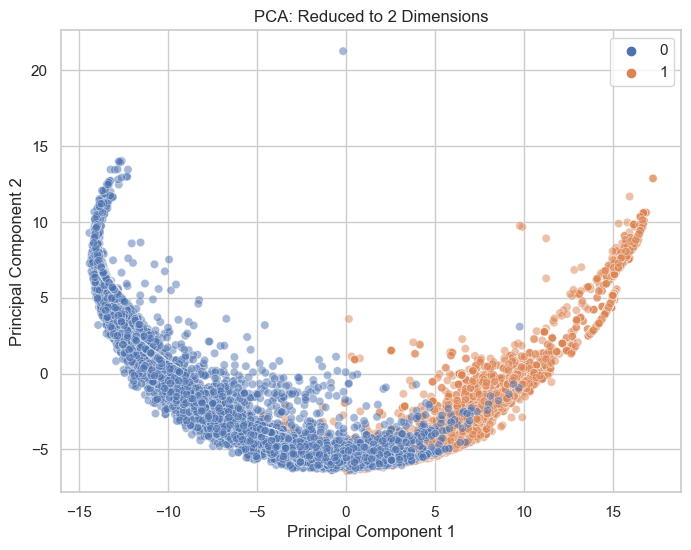

In [46]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Generate some sample data (replace this with your actual data)
edata = embeddings['pair'].numpy()

# Step 1: Standardize the data (important for PCA)
mean = np.mean(edata, axis=0)
std_dev = np.std(edata, axis=0)
standardized_data = (edata - mean) / std_dev

# Step 2: Perform PCA
num_components = 2  # Choose the number of principal components to retain
pca = PCA(n_components=num_components)
principal_components = pca.fit_transform(standardized_data)

# Step 3: Create a Seaborn scatter plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], alpha=0.5, hue=data['pair'].y)
plt.title(f'PCA: Reduced to {num_components} Dimensions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()